In the current, first-price auction-based paradigm, users are presented with three wallet defaults to specify their gas price bids (typically, "slow", "medium" or "fast"), while experienced users can set their own price with advanced settings.

Since [EIP 1559 equilibrates to a market price](https://ethereum.github.io/abm1559/notebooks/stationary1559.html), we look into defaults that embody the price-taking behaviour of users under 1559. Their wallets presents them with a "current transaction price", and a simple **binary option**: transact or not.

This default is likely sufficient for periods where the basefee is relatively stable, but fails to accurately represent user demand when that demand is shifting upwards, since [strategic users](https://ethereum.github.io/abm1559/notebooks/strategicUser.html) enter bidding wars to get ahead. In this case, a wallet could revert to the well-known UX presenting three price levels, with differentiated guarantees for inclusion and delay, which we'll call **expert mode**.

Finding the correct price levels to offer as well as the criteria determining when the UI should switch from the "price-taking" UI to the "shifting demand" UI is discussed via simulations of various demand behaviours. We first import classes from our agent-based transaction market simulation.

In [17]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from typing import Sequence

from abm1559.utils import constants

# Target at most 100 transactions per block
gamma = 250000
constants["SIMPLE_TRANSACTION_GAS"] = gamma

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

from abm1559.txs import Tx1559
from abm1559.config import rng

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

## Simulation components

### Wallet oracle

We introduce a new element sitting between the user and the market, a `WalletOracle` providing the user with the two UIs discussed above. The wallet features two major parameters:

- A criterion deciding when to switch from the binary UI to the expert mode. The criterion takes the form of a parameterised expression:

> Switch to the expert mode whenever the current basefee is $r$% above its moving average of the last $B$ blocks.

- The price levels to suggest the user in expert mode. Although we settle on three price levels, mimicking the current wallets UI, it may be possible to consider two or four or any other number we think reasonable. For each price level, the wallet suggests a different gas premium, following the rule:

> The gas premium $g_i$ of price level $i$ is $c_i$ times the miner minimum premium $\delta$, so $g_i = c_i \cdot \delta$ with $c_i < c_j, \, \forall i < j$.

  In a later analysis, we could investigate a more complex rule
  
> The gas premium $g_i$ of price level $i$ is a function of the recorded premiums in the $B$ last blocks, $g_i = f_i(B_{t-B}, \dots, B_{t-1})$, with $g_i < g_j, \, \forall i < j$.

In [2]:
class WalletOracle:
    
    def __init__(self, sensitivity=0.05, ma_window=5):
        self.sensitivity = sensitivity
        self.ma_window = ma_window
        self.basefees = []
        self.ui_mode = "posted"
        self.expert_defaults = {
            key: { "max_fee": 0, "gas_premium": 0 } for key in ["slow", "medium", "fast"]
        }
        self.min_premium = 1 * (10 ** 9) # in wei
        
    def update_defaults(self, basefee):
        self.basefees = self.basefees[-(self.ma_window - 1):] + [basefee]
        ma_basefee = np.mean(self.basefees)
        
        if (1 + self.sensitivity) * ma_basefee >= basefee:
            # basefee broadly in line with or under its average value in the last blocks
            self.ui_mode = "posted"
            
        else:
            self.ui_mode = "expert"
            self.expert_defaults = {
                "slow": { "max_fee": 2*basefee, "gas_premium": 2*self.min_premium },
                "medium": { "max_fee": 3*basefee, "gas_premium": 3*self.min_premium },
                "fast": { "max_fee": 4*basefee, "gas_premium": 4*self.min_premium },
            }
            
    def get_expert_defaults(self, max_fee):
        return {
            key: {
                "max_fee": min(max_fee, value["max_fee"]),
                "gas_premium": value["gas_premium"],
            } for key, value in self.expert_defaults.items()
        }
            
    def get_defaults(self, speed, max_fee):
        if self.ui_mode == "posted":
            return (self.ui_mode, {
                "max_fee": min([max_fee, max([1.5 * self.basefees[-1], self.basefees[-1] + self.min_premium])]),
                "gas_premium": self.min_premium
            })
        else:
            return (self.ui_mode, self.get_expert_defaults(max_fee)[speed])

### User behaviour with wallets

We define a new `User` class who uses the wallet above to make their pricing decision. This user is an `AffineUser`, and thus experiences a cost for waiting, drawn from a some distribution. We assume that users know their quantile in this distribution. For instance, if we draw costs from a uniform distribution between 0 and 1 Gwei per gas unit, then a user with cost 0.85 knows they are in the 85% quantile.

Users who care a lot about fast inclusion tend to choose the fast default. We'll assume that since users know their quantile, they can also identify whether the slow, medium, or fast default is appropriate for them. Assuming the wallet suggests three price levels, we have two numbers $0 < q_1 < q_2 < 0$ such that:

- Users below quantile $q_1$ choose the slow default.
- Users between quantiles $q_1$ and $q_2$ choose the medium default.
- Users above quantile $q_2$ choose the fast default.

In [3]:
class UserWallet(User1559):
    
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, **kwargs)
        self.value = self.rng.uniform(low=0, high=20) * (10 ** 9)
        self.cost_per_unit = self.rng.uniform(low=0, high=1) * (10 ** 9)
    
    def expected_time(self, params):
        return 0
    
    def decide_parameters(self, env):
        wallet = env["wallet"]
        
        if self.cost_per_unit <= env["cost_quantiles"][0]:
            speed = "slow"
        elif self.cost_per_unit <= env["cost_quantiles"][1]:
            speed = "medium"
        else:
            speed = "fast"
        
        defaults = wallet.get_defaults(speed, self.value)[1]
        
        return {
            **defaults,
            "start_block": self.wakeup_block,
        }

### Transaction pool

We also define the following transaction pool behaviour:

- The maximum number of pending transactions in the pool is limited to 500. With our setting of at most 100 transactions in the block, the pool holds up to 5 full blocks worth of transactions.
- Miners select the highest tip-paying transactions from the pool, where `tip = min(premium, fee_cap - basefee)`, as long as `tip >= MIN_PREMIUM`.
- Whenever too many transactions are added to the pool, the pool is resorted by `tip`, with the lowest tip-paying transactions excluded until the pool limit size is recovered.

In [4]:
MAX_TX_POOL = 500
MIN_PREMIUM = 1e9

class TxPoolLimit(TxPool):
    
    def __init__(self, max_txs=MAX_TX_POOL, min_premium=MIN_PREMIUM, **kwargs):
        super().__init__(**kwargs)
        self.max_txs = max_txs
        self.min_premium = MIN_PREMIUM
    
    def add_txs(self, txs: Sequence[Tx1559], env: dict) -> Sequence[Tx1559]:
        for tx in txs:
            self.txs[tx.tx_hash] = tx
                    
        if self.pool_length() > self.max_txs:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:self.max_txs], env)
            return sorted_txs[self.max_txs:]
        
        return []

class TxPool1559(TxPoolLimit):
    
    def select_transactions(self, env, user_pool=None, rng=rng) -> Sequence[Tx1559]:
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(env) and tx.tip(env) >= self.min_premium]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs

### Running the simulation

The usual simulation loop...

In [5]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool1559()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    wallet = WalletOracle()

    for t in tqdm(range(len(demand_scenario)), desc="simulation loop", leave=False):
        
        # Update oracle
        wallet.update_defaults(basefee)
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        cost_quantiles = np.quantile([u.cost_per_unit for u in users], q = [0.4, 0.75, 0.95])
        
        # `params` are the "environment" of the simulation
        env = {
            "basefee": basefee,
            "current_block": t,
            "wallet": wallet,
            "cost_quantiles": cost_quantiles,
        }
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)
        
        # The block is added to the chain
        chain.add_block(block)

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "ui_mode": wallet.ui_mode,
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length(),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [6]:
blocks = 100
demand_scenario = [250 for i in range(blocks)]

shares_scenario = [{
    UserWallet: 1
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

simulation loop:   0%|          | 0/100 [00:00<?, ?it/s]

## Some results

We see the `ui_mode` switching to `expert` mode from block 1 onwards, picking up a demand shift important enough to allow users to choose their price level.

By block 25, when the basefee stabilises, the UI switches back to the `posted` price binary option.

In [7]:
df[(df.block <= 30)]

,block,basefee,ui_mode,users,decided_txs,included_txs,blk_min_premium,blk_avg_gas_price,blk_avg_tip,pool_length,gas_used
0,0,1.000000,posted,248,230,100,1.0,2.000000,1.000000,130,25000000
1,1,1.125000,expert,251,205,100,3.0,3.926250,2.801250,235,25000000
2,2,1.265625,expert,241,199,100,3.0,4.404375,3.138750,334,25000000
3,3,1.423828,expert,239,197,100,3.0,4.813086,3.389258,400,25000000
4,4,1.601807,expert,281,219,100,3.0,5.061807,3.460000,400,25000000
5,5,1.802032,expert,245,198,100,3.0,5.212032,3.410000,400,25000000
6,6,2.027287,expert,248,190,100,3.0,5.497287,3.470000,400,25000000
7,7,2.280697,expert,240,176,100,3.0,5.590697,3.310000,400,25000000
8,8,2.565785,expert,249,195,100,3.0,6.035785,3.470000,400,25000000
9,9,2.886508,expert,254,187,100,3.0,6.306508,3.420000,400,25000000


<AxesSubplot:xlabel='block'>

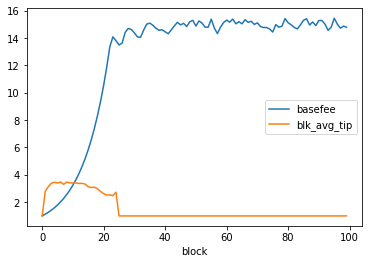

In [8]:
df.plot("block", ["basefee", "blk_avg_tip"])

In [9]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

In [10]:
bins = 20
user_txs_df["user_sw"] = user_txs_df.apply(
    lambda row: row.value - (row.block_height - row.start_block) * row.cost_per_unit - (row.basefee + row.tip / (10 ** 9)),
    axis=1
)
user_txs_df["value_bin"] = pd.cut(user_txs_df["value"], bins=np.linspace(0, 20, bins+1))
user_txs_df["cost_bin"] = pd.cut(user_txs_df["cost_per_unit"], bins=np.linspace(0, 1, bins+1))
grouped = user_txs_df.groupby(["block_height", "value_bin", "cost_bin"]).mean().reset_index()

### Plots

Utility obtained by users with various value/cost per unit combinations at block 2. Higher value users have higher utility (they are getting a good deal for inclusion!)

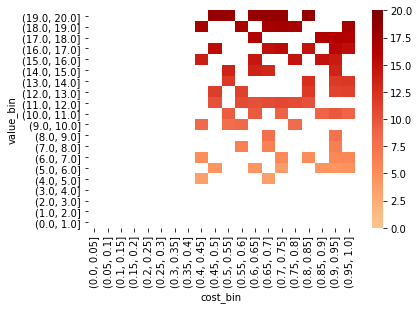

In [16]:
ax = sns.heatmap(grouped[grouped.block_height == 2].pivot("value_bin", "cost_bin", "user_sw"), vmin=0, vmax=20, cmap="OrRd", center=5)
ax.invert_yaxis()

Over time, low value users become priced out. Observe too that between block 1 and 14, users with low cost per unit of time are also priced out: given the high congestion, users with high cost per unit of time who use the "fast" wallet default are included in priority. After block 14, once basefee is high enough, all higher value users, regardless of their cost per time unit, have a chance at inclusion.

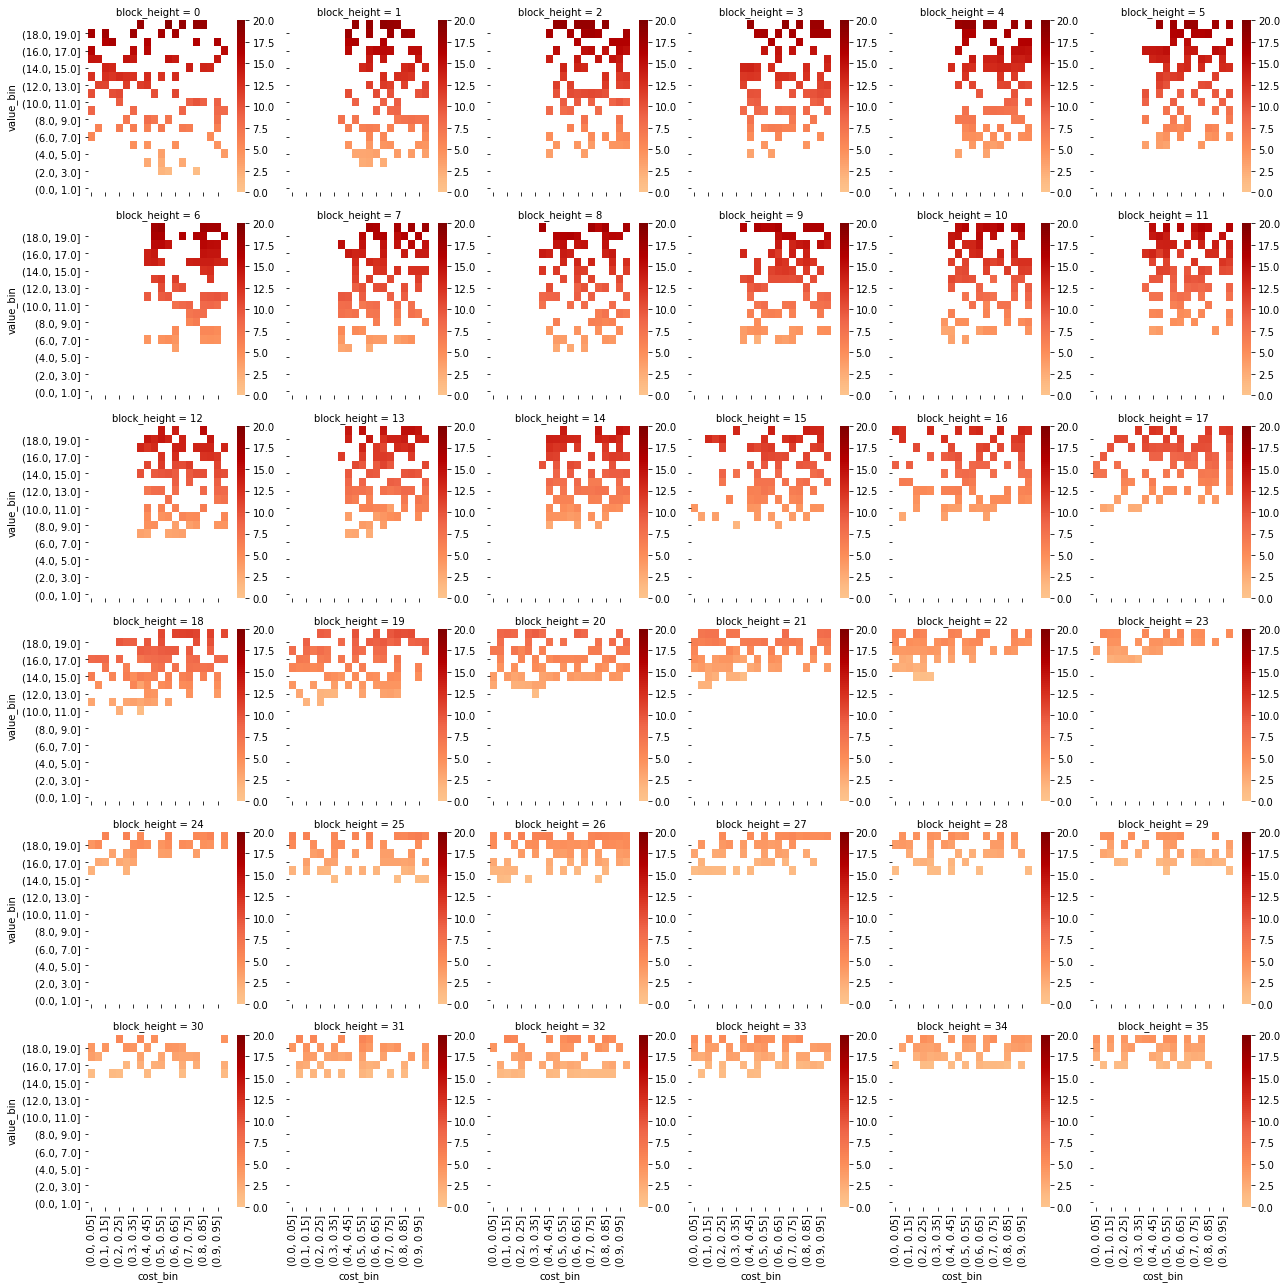

In [15]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, **kwargs, vmin=0, vmax=20, cmap="OrRd", center=5)
    ax.invert_yaxis()

grid_size = 6
fg = sns.FacetGrid(grouped[grouped.block_height < grid_size ** 2], col='block_height', col_wrap = grid_size)
fg.map_dataframe(draw_heatmap, 'cost_bin', 'value_bin', 'user_sw')